In [2]:
# To supress DPT and Mask2Former warnings
import warnings
warnings.filterwarnings("ignore")

import os
import cv2

import numpy as np
from PIL import Image
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt

import torch
import torchvision.transforms.functional as TF
from einops import rearrange

# Mask2Former and detectron2 dependencies for semantic segmentation pseudo labeling
from detectron2.data import MetadataCatalog
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# DPT dependencies for depth pseudo labeling
from pipelines.utils.data_utils import preprocess_multimae_inputs_in_batch
from multimae.utils.plot_utils import plot_predictions
from multimae.models.input_adapters import PatchedInputAdapter, SemSegInputAdapter
from multimae.models.output_adapters import SpatialOutputAdapter
from multimae.models.multimae import pretrain_multimae_base

torch.set_grad_enabled(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vb_folder = Path(os.getcwd()) / "vision_backbones"

In [3]:
DOMAIN_CONF = {
    'rgb': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=3, stride_level=1),
    },
    'depth': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=1, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=1, stride_level=1),
    },
    'semseg': {
        'input_adapter': partial(SemSegInputAdapter, num_classes=133,
                                 dim_class_emb=64, interpolate_class_emb=False, stride_level=4),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=133, stride_level=4),
    },
}
DOMAINS = ['rgb', 'depth', 'semseg']

input_adapters = {
    domain: dinfo['input_adapter'](
        patch_size_full=16,
    )
    for domain, dinfo in DOMAIN_CONF.items()
}
output_adapters = {
    domain: dinfo['output_adapter'](
        patch_size_full=16,
        dim_tokens=256,
        use_task_queries=True,
        depth=2,
        context_tasks=DOMAINS,
        task=domain
    )
    for domain, dinfo in DOMAIN_CONF.items()
}

multimae = pretrain_multimae_base(
    input_adapters=input_adapters,
    output_adapters=output_adapters,
)

CKPT_URL = 'https://github.com/EPFL-VILAB/MultiMAE/releases/download/pretrained-weights/multimae-b_98_rgb+-depth-semseg_1600e_multivit-afff3f8c.pth'
ckpt = torch.hub.load_state_dict_from_url(CKPT_URL, map_location='cpu')
multimae.load_state_dict(ckpt['model'], strict=False)
multimae = multimae.to(device).eval()


## 3 MultiMAE prediction

Try out MultiMAE by loading any RGB image from a URL using this form:

## get custom test inputs

(224, 224, 3)


(-0.5, 639.5, 479.5, -0.5)

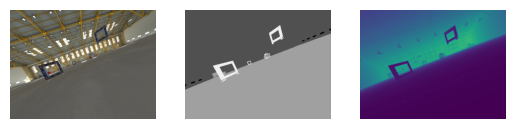

In [7]:
from pipelines.utils.data_utils import normalize2d_scale, normalize2d_robust
    
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
sample_rgb = multimae_path / "samples/rgb.png"
sample_depth = multimae_path / "samples/depth.npy"
sample_semseg = multimae_path / "samples/semseg.png"

image = cv2.imread(str(sample_rgb))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
c, h, w = image_float.shape

image_float = TF.center_crop(image_float, min([h, w]))
image_float = TF.resize(image_float, 224)
image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
print(image_float.shape)

image = Image.fromarray(image)

semseg = cv2.imread(str(sample_semseg))
depth = np.load(str(sample_depth))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

axs[1].imshow(semseg * 80)
axs[1].axis('off')

axs[2].imshow(depth)
axs[2].axis('off')

Make predictions with a random mask. The mask is sampled during the forward pass and returned, as an output, so you can modify it manually and pass as input (see example below).

In [8]:
# Pre-process RGB, depth and semseg to the MultiMAE input format

input_dict = {
    "rgb": np.expand_dims(image, [0, -1]),
    "depth": np.expand_dims(depth, [0, -1]),
    "semseg": np.expand_dims(semseg[:, :, 0], [0, 3, 4])
}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

inputs = preprocess_multimae_inputs_in_batch(input_dict, batch_axis=True)
    
# To GPU
inputs = {k: v.squeeze(-1).to("cuda") for k,v in inputs.items()}

print(inputs["rgb"].shape)
print(inputs["depth"].shape)
print(inputs["semseg"].shape)

(1, 480, 640, 3, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 1, 1)
torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 56, 56])


tensor(78)
tensor(118)


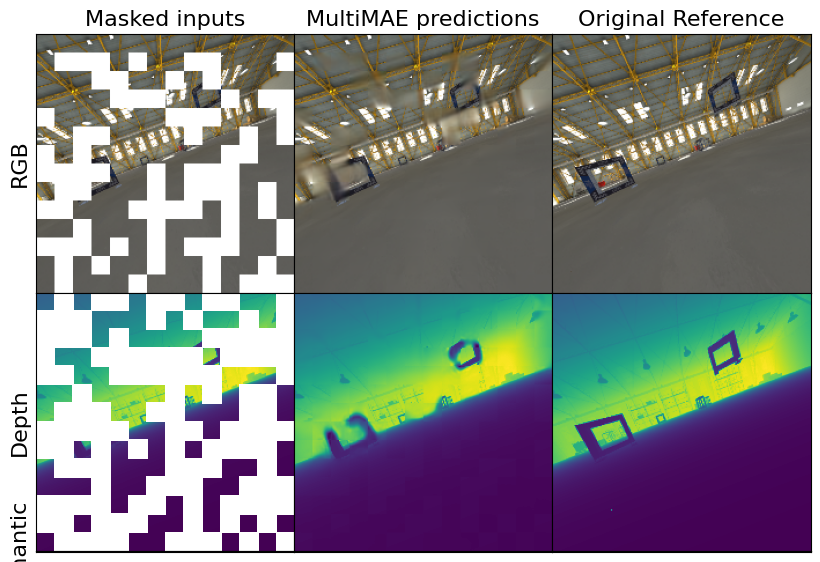

In [10]:
torch.manual_seed(1) # change seed to resample new mask
num_encoded_tokens = 196 # the number of visible tokens
alphas = 1.0 # Dirichlet concentration parameter

inputs = {k: v.to(device) for k, v in inputs.items() if k in ["rgb", "depth"]}

preds, masks = multimae(
    inputs, 
    mask_inputs=True, # True if forward pass should sample random masks
    num_encoded_tokens=num_encoded_tokens,
    alphas=alphas
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

print(masks["rgb"].sum())
print(masks["depth"].sum())

res = plot_predictions(inputs, preds, masks)

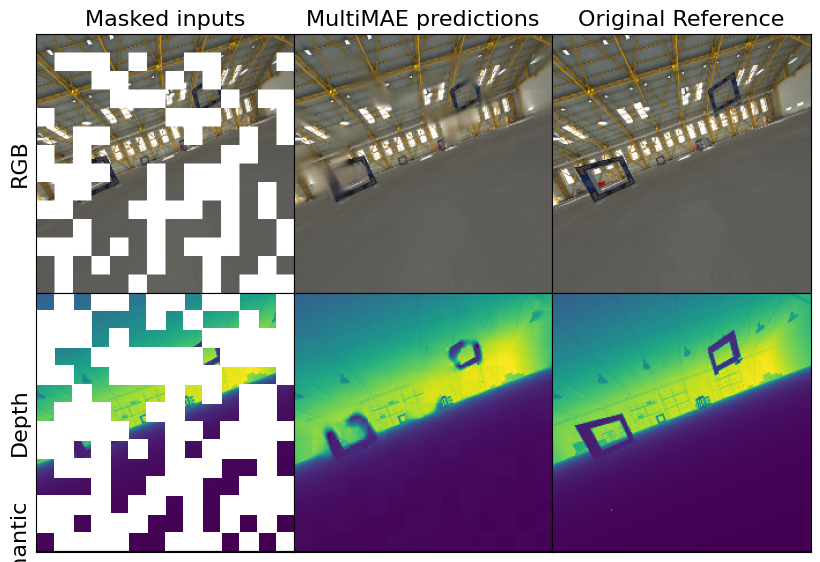

In [12]:
task_masks = {k: v.to(device) for k, v in masks.items()}

preds, masks = multimae.forward(
    inputs, 
    mask_inputs=True,
    task_masks=task_masks
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(inputs, preds, masks)

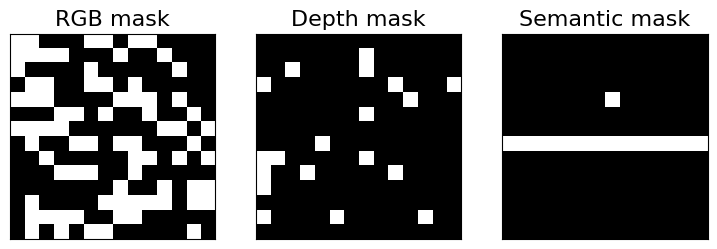

In [13]:
mask = {}

mask['rgb'] = np.array([
    [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1],
    [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
    [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
])


mask['depth'] = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

mask['semseg'] = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(1-mask['rgb'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('RGB mask', size=16)

plt.subplot(1, 3, 2)
plt.imshow(1-mask['depth'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Depth mask', size=16)

plt.subplot(1, 3, 3)
plt.imshow(1-mask['semseg'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Semantic mask', size=16);



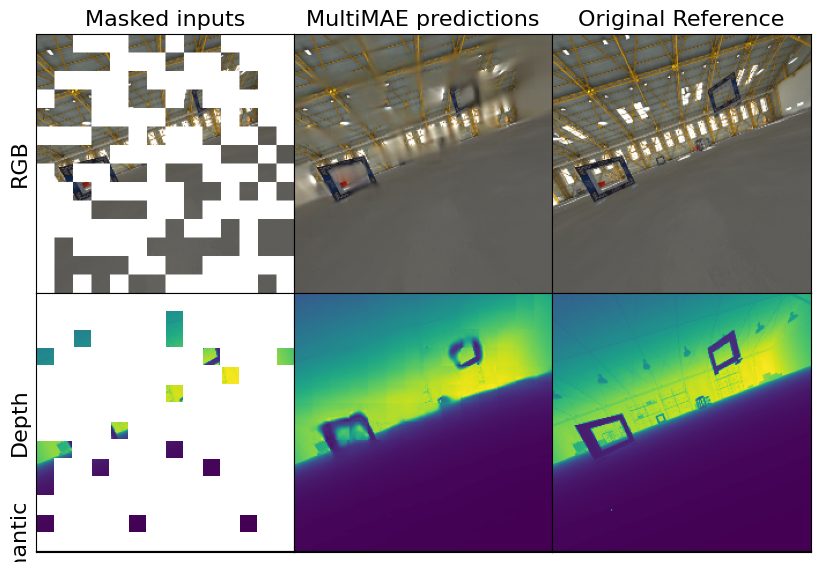

In [14]:
task_masks = {k: torch.LongTensor(v).flatten()[None].to(device) for k, v in mask.items()}
preds, masks = multimae.forward(
    inputs, 
    mask_inputs=True,
    task_masks=task_masks
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(inputs, preds, masks)